# INFO 3950 Mini-Project

name: Kate Li

netid: kl739

[RMP dataset from kaggle](https://www.kaggle.com/datasets/andreaspavlopoulos/prof-ratings-9c/data)

Used both a simple sentiment analysis and a binary single layer neural net to analyze a model's performance on predicting sentiment of professor reviews from Ratemyprofessor.

I was actually a little surprised that the models performed at only around 80-85% accuracy. I assumed that most professor ratings are rather straightforward with easily detectable sentiments in words (i.e. awesome, bad, etc.). I believe that some reviews contained more ambiguous wording, meaning that the review had a mix of both positive and negative which can lead to the confusion displayed by the models.

In [2]:
import pandas as pd
import numpy as np

In [3]:
# load and prepare data
rmp = pd.read_csv('rmp.csv')
rmp = rmp.loc[:, ['student_star', 'comments']]
rmp['student_star'] = pd.to_numeric(rmp['student_star'], errors = 'coerce')
rmp = rmp.rename(columns = {'student_star': 'star'})
rmp.head()

,star,comments
0,5.0,This class is hard but its a two-in-one gen-e...
1,5.0,Definitely going to choose Prof. Looney's clas...
2,4.0,I overall enjoyed this class because the assig...
3,5.0,Yes it's possible to get an A but you'll defi...
4,5.0,Professor Looney has great knowledge in Astron...


In [4]:
# create function and column with binary labels based on the star ratings
def rate_to_label(star):
    if star >= 4:
        return 1
    else:
        return 0

rmp['label'] = rmp['star'].apply(rate_to_label)
rmp.head()

,star,comments,label
0,5.0,This class is hard but its a two-in-one gen-e...,1
1,5.0,Definitely going to choose Prof. Looney's clas...,1
2,4.0,I overall enjoyed this class because the assig...,1
3,5.0,Yes it's possible to get an A but you'll defi...,1
4,5.0,Professor Looney has great knowledge in Astron...,1


## 1) Sentiment Analysis

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [7]:
# tf_idf feature vectors
tfidf = TfidfVectorizer(max_features = 10000)
X = tfidf.fit_transform(rmp['comments'].astype(str))

X_train, X_test, y_train, y_test = train_test_split(X, rmp['label'], test_size = 0.1, random_state = 42)

In [8]:
# logreg model trained on train set
clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [9]:
# obtain scores based on test set
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"train accuracy score = {train_accuracy:.6f}")
print(f"test accuracy score = {test_accuracy:.6f}")

train accuracy score = 0.856341
test accuracy score = 0.823000


In [10]:
print(classification_report(y_test, y_test_pred, target_names = ['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.77      0.80      0.78       802
    positive       0.86      0.84      0.85      1198

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

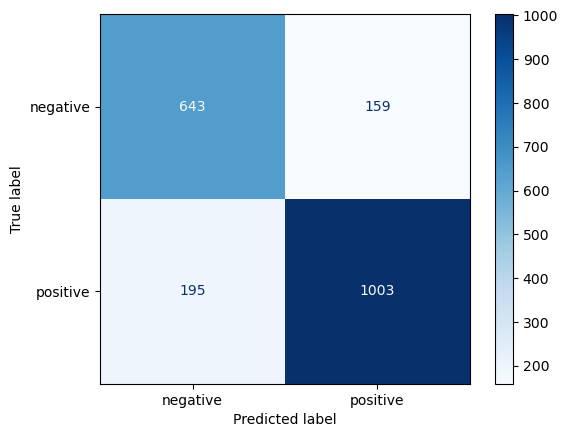

In [12]:
cm = confusion_matrix(y_test, y_test_pred)

display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['negative', 'positive'])
display.plot(cmap = 'Blues')

In [13]:
# top 20 positive and negative words used
tfidf_words = np.array(tfidf.get_feature_names_out())

top_pos_idx = np.argsort(clf.coef_.flatten())[-20:]
top_neg_idx = np.argsort(clf.coef_.flatten())[:20]

print(f"top 20 positive words: {tfidf_words[top_pos_idx]}")
print(f"top 20 negative words: {tfidf_words[top_neg_idx]}")

top 20 positive words: ['keeps' 'always' 'professor' 'you' 'fair' 'highly' 'cares' 'love'
 'enjoyed' 'hilarious' 'easy' 'loved' 'fun' 'excellent' 'helpful'
 'wonderful' 'amazing' 'awesome' 'best' 'great']
top 20 negative words: ['worst' 'not' 'avoid' 'horrible' 'rude' 'confusing' 'terrible' 'unclear'
 'boring' 'nothing' 'awful' 'doesn' 'never' 'thinks' 'arrogant'
 'unorganized' 'sucks' 'luck' 'useless' 'unhelpful']


## 2) Binary Single Layer Neural Net

In [15]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

In [16]:
# function for tokenization and removal of stopwords
stop_words = set(stopwords.words('english'))
def words(text):
    words = re.findall(r"\b\w+'\w+|\b\w+\b", text.lower())
    words = [word for word in words if word not in stop_words]
    return words

In [17]:
tokenized_words = rmp['comments'].astype(str).apply(words)
print(tokenized_words.head())

0    [class, hard, two, one, gen, ed, knockout, con...
1    [definitely, going, choose, prof, looney's, cl...
2    [overall, enjoyed, class, assignments, straigh...
3    [yes, possible, get, definitely, work, content...
4    [professor, looney, great, knowledge, astronom...
Name: comments, dtype: object


In [18]:
# counter object with 10000 most common words used in ratings
word_counter = Counter()
for w in tokenized_words:
    word_counter.update(w)

vocab, vocabn = zip(*word_counter.most_common(10000))

In [19]:
vocab_dict = {word: index for index, word in enumerate(vocab)}
Nf = len(vocab_dict)

In [20]:
# create function for binary bag-of-words feature vector
def features(text):
    f = np.zeros(Nf)
    for w in set(words(text)):
        if w in vocab_dict:
            f[vocab_dict[w]] = 1
    return f

In [21]:
X_data = np.array([features(text) for text in rmp['comments'].astype(str)])
y_data = np.array(rmp['label'])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.1, random_state = 42)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

In [24]:
# create binary neural net model with a single layer
nn_model = nn.Sequential(
    nn.Linear(10000, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

learning_rate = 1e-3;
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr = learning_rate)

In [25]:
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float().unsqueeze(1)

X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float().unsqueeze(1)

In [26]:
# train and test scores for each epoch
epochs = 40
scores = []
losses = []
#test_losses = []

for t in range(epochs):
    print(f'Epoch {t+1}: ', end='')

    nn_model.train() #turns on dropout
    # Compute prediction and loss
    pred = nn_model(X_train_tensor)
    loss = loss_fn(pred, y_train_tensor)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    nn_model.eval()  #turns off dropout
    test_pred = nn_model(X_test_tensor)
    test_loss = loss_fn(test_pred, y_test_tensor)
    losses.append((loss.item(), test_loss.item()))

    train_pred_labels = (pred >= 0.5).float()
    test_pred_labels = (test_pred >= 0.5).float()
                  
    train_score = (train_pred_labels == y_train_tensor).sum().item() / len(y_train_tensor)
    test_score = (test_pred_labels == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'loss={loss.item():.3f}, training_score={train_score:.1%}, test_score={test_score:.1%}')
    scores.append((train_score, test_score))

Epoch 1: loss=0.693, training_score=56.6%, test_score=60.5%
Epoch 2: loss=0.685, training_score=60.7%, test_score=61.4%
Epoch 3: loss=0.677, training_score=62.3%, test_score=62.6%
Epoch 4: loss=0.669, training_score=64.3%, test_score=64.5%
Epoch 5: loss=0.659, training_score=66.4%, test_score=66.6%
Epoch 6: loss=0.649, training_score=68.6%, test_score=68.5%
Epoch 7: loss=0.638, training_score=70.7%, test_score=70.2%
Epoch 8: loss=0.628, training_score=72.6%, test_score=72.7%
Epoch 9: loss=0.617, training_score=74.6%, test_score=73.7%
Epoch 10: loss=0.607, training_score=76.4%, test_score=74.4%
Epoch 11: loss=0.596, training_score=77.6%, test_score=75.1%
Epoch 12: loss=0.585, training_score=78.7%, test_score=75.9%
Epoch 13: loss=0.575, training_score=79.5%, test_score=76.8%
Epoch 14: loss=0.565, training_score=80.0%, test_score=77.3%
Epoch 15: loss=0.554, training_score=80.7%, test_score=77.9%
Epoch 16: loss=0.544, training_score=81.1%, test_score=78.2%
Epoch 17: loss=0.534, training_sc

In [27]:
import matplotlib.pyplot as plt

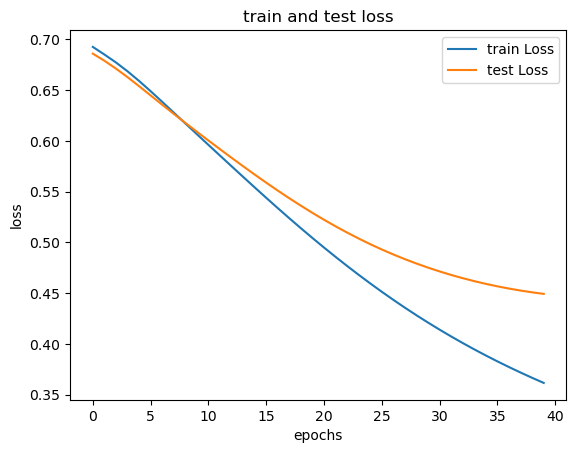

In [28]:
train_losses, test_losses = zip(*losses)

plt.plot(range(epochs), train_losses, label = 'train Loss')
plt.plot(range(epochs), test_losses, label = 'test Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('train and test loss')
plt.show()

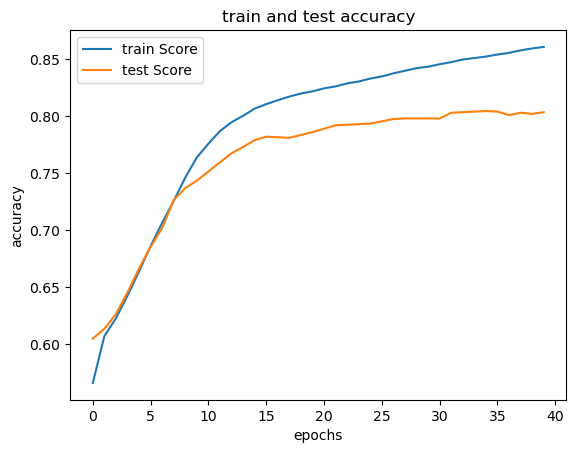

In [29]:
train_scores, test_scores = zip(*scores)

plt.plot(range(epochs), train_scores, label = 'train Score')
plt.plot(range(epochs), test_scores, label = 'test Score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('train and test accuracy')
plt.show()

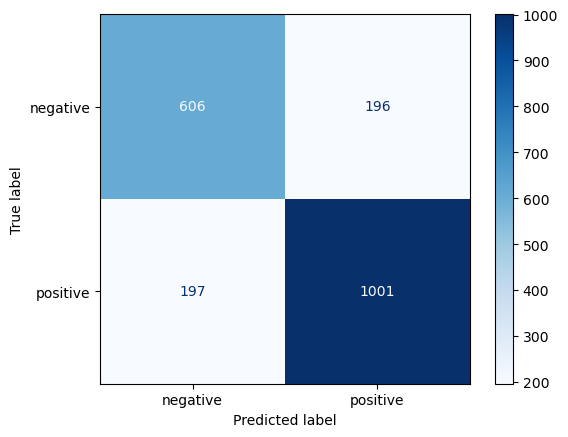

In [30]:
y_true = y_test_tensor.numpy()
y_pred = test_pred_labels.numpy()

cm = confusion_matrix(y_true, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['negative', 'positive'])
display.plot(cmap = 'Blues')

In [31]:
# testing the model on new comments
new_comments = [
    "The professor was very helpful and explained everything clearly.",
    "This class was disorganized and the grading was unfair.",
    "I learned a lot and would recommend this professor. Tough class but the professor made it doable.",
    "Terrible experience, would not take this course again.",
    "The professor was nice and tried to help his students, but he was unorganized and his exams were unfairly difficult."
]

In [32]:
new_features = [features(comment) for comment in new_comments]
new_tensor = torch.tensor(new_features).float()

nn_model.eval()
with torch.no_grad():
    pred = nn_model(new_tensor)

pred_labels = (pred >= 0.5).int().squeeze().tolist()

/var/folders/53/v8gmjymx1ms1ccqfn00fp1mw0000gn/T/ipykernel_36014/2620310948.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  new_tensor = torch.tensor(new_features).float()


In [33]:
for comment, label in zip(new_comments, pred_labels):
    sentiment = "Positive" if label == 1 else "Negative"
    print(f'"{comment}", {sentiment.upper()}')

"The professor was very helpful and explained everything clearly.", POSITIVE
"This class was disorganized and the grading was unfair.", NEGATIVE
"I learned a lot and would recommend this professor. Tough class but the professor made it doable.", POSITIVE
"Terrible experience, would not take this course again.", NEGATIVE
"The professor was nice and tried to help his students, but he was unorganized and his exams were unfairly difficult.", NEGATIVE
